# Image Recognition: Deep Learning to Detect Euro and Dirham Currency

## Realiser par : Houda Mesbahi

In [1]:
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import os

## 1. Chargement de donnees


In [2]:
import numpy as np
from PIL import Image

def load_data(data_path, classes, dataset="train", image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + '/' + dataset + '/' + classes[i]))
        num_images += len(dirs)

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, len(classes)))

    current_index = 0

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + '/' + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)

        # Chargement des images,
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + '/' + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + '/' + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index][idx_class] = 1
                current_index += 1

    return x, y

In [3]:
from sklearn.model_selection import train_test_split

path = os.path.abspath('dataset/')

labels = ['1c', '2c', '5c', '10c', '20c', '50c', '1e', '2e',
          '1Dh', '2Dh', '5Dh', '10Dh', '50Franc', '10Franc', '20Franc']

X, y = load_data(path, labels, image_size=150)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Dataset total:', X.shape[0])
print("Shape des dataset:", X_train.shape, X_test.shape, X_val.shape)
print("Shape des labels:", y_train.shape, y_test.shape, y_val.shape)
print("Pourcentage de donnees d'entrainement:", X_train.shape[0] / X.shape[0])
print("Pourcentage de donnees de test:", X_test.shape[0] / X.shape[0])
print("Pourcentage de donnees de validation:", X_val.shape[0] / X.shape[0])

Dataset total: 12228
Shape des dataset: (7825, 150, 150, 3) (2446, 150, 150, 3) (1957, 150, 150, 3)
Shape des labels: (7825, 15) (2446, 15) (1957, 15)
Pourcentage de donnees d'entrainement: 0.639924762839385
Pourcentage de donnees de test: 0.20003271180896304
Pourcentage de donnees de validation: 0.16004252535165195


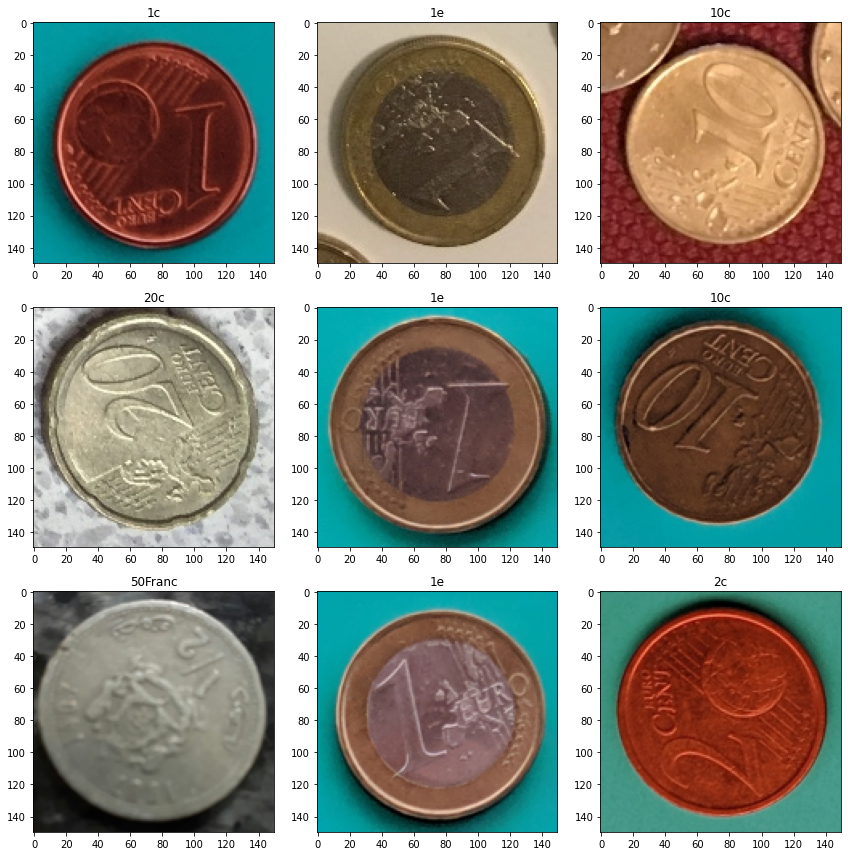

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(len(X_train))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = X_train[shuffle_indices[i]]
    index = list(y_train[shuffle_indices[i]]).index(1)
    plt.title(labels[index])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator_augmented = train_datagen.flow(
    X_train,
    y_train
)

In [6]:
# Result plot
def plot_training_analysis(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

#### Definition du modele

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Dense

from keras.layers import MaxPooling2D

model = Sequential()

#Convolution
model.add(Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(96, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())

#Flatten
model.add(Flatten())

# Fully connected
model.add(Dense(512, activation='relu', input_dim=128))
model.add(Dense(15, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 96)       0

Apprentissage du modele

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
245/245 [==============================] - 61s 242ms/step - loss: 0.1682 - acc: 0.5352 - val_loss: 0.1090 - val_acc: 0.6367
Epoch 2/20
245/245 [==============================] - 58s 236ms/step - loss: 0.0838 - acc: 0.7375 - val_loss: 0.0740 - val_acc: 0.7603
Epoch 3/20
245/245 [==============================] - 58s 239ms/step - loss: 0.0633 - acc: 0.8147 - val_loss: 0.0637 - val_acc: 0.8058
Epoch 4/20
245/245 [==============================] - 62s 251ms/step - loss: 0.0500 - acc: 0.8564 - val_loss: 0.0519 - val_acc: 0.8472
Epoch 5/20
245/245 [==============================] - 61s 248ms/step - loss: 0.0389 - acc: 0.8892 - val_loss: 0.0435 - val_acc: 0.8799
Epoch 6/20
245/245 [==============================] - 60s 245ms/step - loss: 0.0349 - acc: 0.9029 - val_loss: 0.0488 - val_acc: 0.8717
Epoch 7/20
245/245 [==============================] - 59s 242ms/step - loss: 0.0292 - acc: 0.9222 - val_loss: 0.0473 - val_acc: 0.8799
Epoch 8/20
245/245 [==============================] - 6

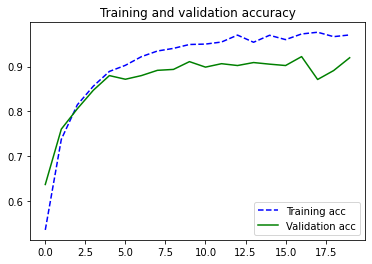

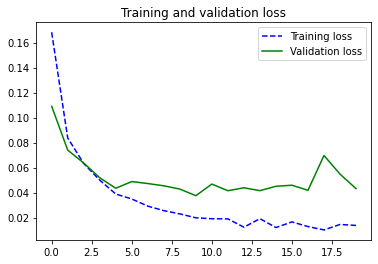

In [9]:
plot_training_analysis(history)

Evaluation du modele sur les donnees test, afin de verifier la marge d'erreur qu'il a obtenu.

In [10]:
loss = model.evaluate(X_test, y_test, steps=len(X_test))

2446/2446 [==============================] - 9s 4ms/step - loss: 0.0418 - acc: 0.9297


#### Faire les predictions

Test du model sur les données de test.

In [11]:
def datasetTo1D(array):
    amax = np.amax(array, axis=1)
    res = []
    for i in range(len(array)):
        m = np.where(array[i] == amax[i])[0][0]
        res.append(m)
    return res

In [12]:
predictions = model.predict(X_test)
predictions_1D = datasetTo1D(predictions)
y_test_1D = datasetTo1D(y_test)

In [13]:
from sklearn.metrics import classification_report

cf = classification_report(y_test_1D, predictions_1D, target_names=labels)
print(cf)

              precision    recall  f1-score   support

          1c       0.98      0.97      0.98       261
          2c       0.95      0.91      0.93       208
          5c       0.93      0.98      0.95       359
         10c       0.92      0.94      0.93       323
         20c       0.87      0.93      0.90       306
         50c       0.94      0.93      0.94       275
          1e       0.98      0.97      0.97       288
          2e       0.97      0.96      0.96       236
         1Dh       0.75      0.69      0.72        26
         2Dh       0.93      0.65      0.76        20
         5Dh       0.80      0.86      0.83        28
        10Dh       1.00      0.81      0.89        21
     50Franc       0.89      0.47      0.62        17
     10Franc       0.75      0.60      0.67        50
     20Franc       0.61      0.61      0.61        28

    accuracy                           0.93      2446
   macro avg       0.88      0.82      0.84      2446
weighted avg       0.93   

Sauvegarde du modele

#### Sauvegarder le modele

In [14]:
model.save('mode_prediction_eu_mad.h5')